# 01_EDA - Exploratory Data Analysis

This notebook loads the dataset using `src/load_data.py`, prints basic information, and creates simple plots (class distribution, amount distribution, correlation heatmap). If no CSV is found in `../data/raw/`, it will ask you to place the file there.

In [2]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from load_data import load_dataset, save_sample

RAW_DIR = os.path.abspath(os.path.join('..', 'data', 'raw'))
csv_files = [f for f in os.listdir(RAW_DIR) if f.lower().endswith('.csv')] if os.path.exists(RAW_DIR) else []
if not csv_files:
    print('No CSV files found in data/raw. Please place the dataset CSV in data/raw and re-run this cell.')
else:
    dataset_path = os.path.join(RAW_DIR, csv_files[0])
    df = load_dataset(dataset_path)
    save_sample(df, os.path.join(RAW_DIR, 'sample.csv'), sample_size=500)
    print(f'Loaded dataset with {len(df)} rows and {len(df.columns)} columns.')


Loading dataset from: c:\Users\mazen\Desktop\Uni\Term 9\Data Mining\Anti-Money Laundering (AML) Detection System\aml_project\data\raw\SAML-D.csv

Dataset loaded successfully!
Shape: 9504852 rows, 12 columns

First 5 rows:
       Time        Date  Sender_account  Receiver_account    Amount  \
0  10:35:19  2022-10-07      8724731955        2769355426   1459.15   
1  10:35:20  2022-10-07      1491989064        8401255335   6019.64   
2  10:35:20  2022-10-07       287305149        4404767002  14328.44   
3  10:35:21  2022-10-07      5376652437        9600420220  11895.00   
4  10:35:21  2022-10-07      9614186178        3803336972    115.25   

  Payment_currency Received_currency Sender_bank_location  \
0        UK pounds         UK pounds                   UK   
1        UK pounds            Dirham                   UK   
2        UK pounds         UK pounds                   UK   
3        UK pounds         UK pounds                   UK   
4        UK pounds         UK pounds          

## Dataset Info

In [3]:
print('\nInfo:')
print(df.info())

print('\nDescribe:')
display(df.describe(include='all'))


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9504852 entries, 0 to 9504851
Data columns (total 12 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Time                    object 
 1   Date                    object 
 2   Sender_account          int64  
 3   Receiver_account        int64  
 4   Amount                  float64
 5   Payment_currency        object 
 6   Received_currency       object 
 7   Sender_bank_location    object 
 8   Receiver_bank_location  object 
 9   Payment_type            object 
 10  Is_laundering           int64  
 11  Laundering_type         object 
dtypes: float64(1), int64(3), object(8)
memory usage: 870.2+ MB
None

Describe:


,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
count,9504852,9504852,9.504852e+06,9.504852e+06,9.504852e+06,9504852,9504852,9504852,9504852,9504852,9.504852e+06,9504852
unique,86400,321,NaN,NaN,NaN,13,13,18,18,7,NaN,28
top,15:22:42,2023-02-09,NaN,NaN,NaN,UK pounds,UK pounds,UK,UK,Credit card,NaN,Normal_Small_Fan_Out
freq,201,36645,NaN,NaN,NaN,9099293,8783655,9183088,8864634,2012909,NaN,3477717
mean,NaN,NaN,5.006619e+09,5.006006e+09,8.762968e+03,NaN,NaN,NaN,NaN,NaN,1.038733e-03,NaN
std,NaN,NaN,2.885814e+09,2.884763e+09,2.561495e+04,NaN,NaN,NaN,NaN,NaN,3.221263e-02,NaN
min,NaN,NaN,9.018000e+03,9.018000e+03,3.730000e+00,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN
25%,NaN,NaN,2.513133e+09,2.513219e+09,2.143688e+03,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN
50%,NaN,NaN,5.001017e+09,5.002572e+09,6.113720e+03,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN
75%,NaN,NaN,7.505051e+09,7.502397e+09,1.045846e+04,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN


## Class Distribution (is_laundring)

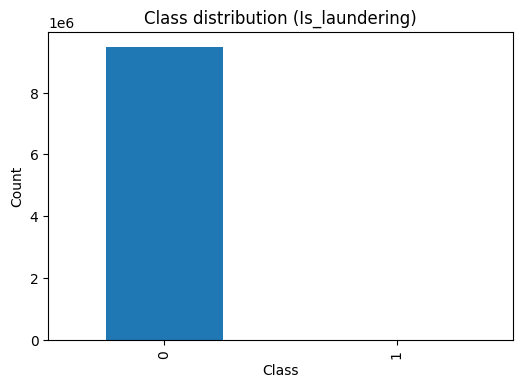


Class counts:
Is_laundering
0    9494979
1       9873
Name: count, dtype: int64


In [7]:
if 'Is_laundering' in df.columns:
    counts = df['Is_laundering'].value_counts(dropna=False)
    plt.figure(figsize=(6,4))
    counts.plot(kind='bar')
    plt.title('Class distribution (Is_laundering)')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()
    print(f'\nClass counts:\n{counts}')
else:
    print('Column "Is_laundering" not found in dataset.')

## Correlation Heatmap (All Features)

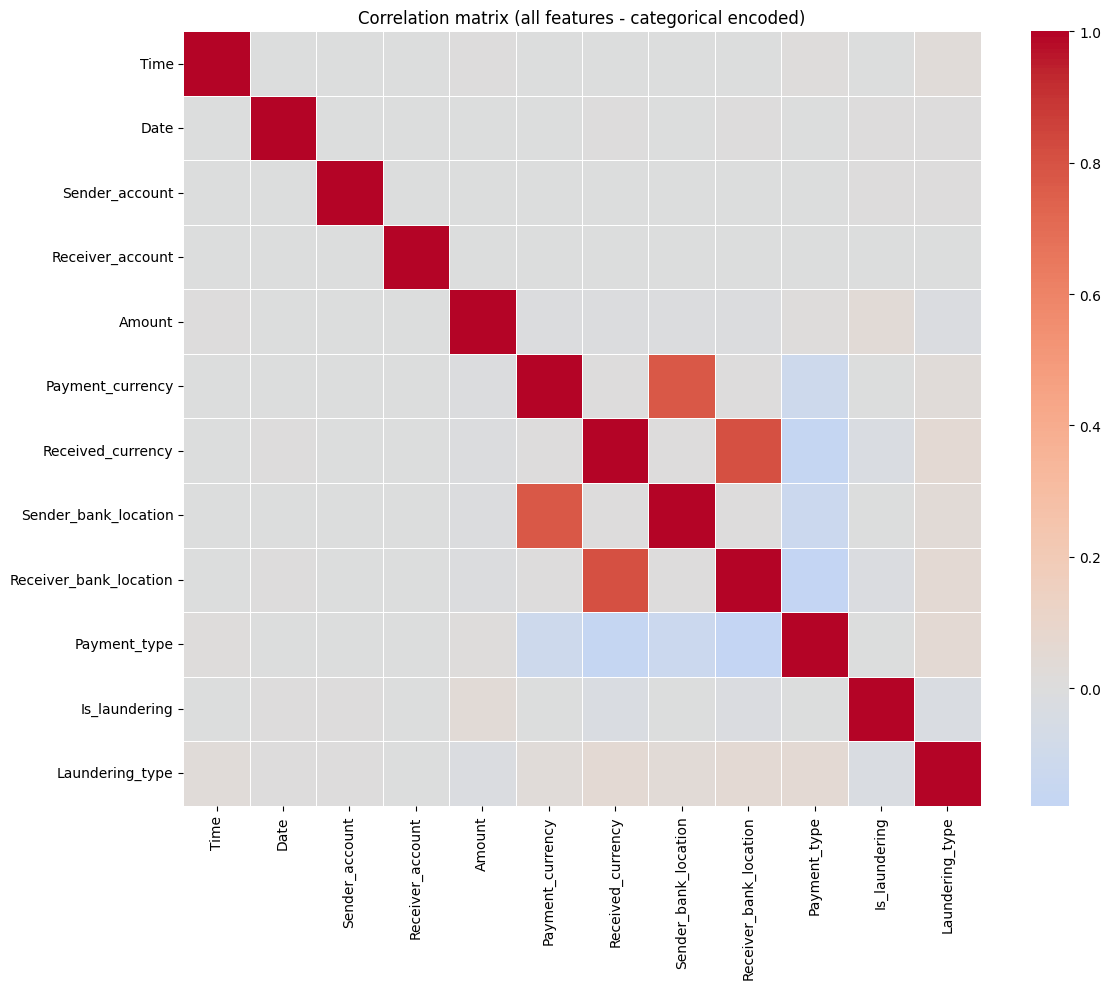

In [6]:
# Create a copy for encoding
df_encoded = df.copy()

# Encode categorical/object columns as numeric
for col in df_encoded.columns:
    if df_encoded[col].dtype == 'object' or df_encoded[col].dtype.name == 'category':
        df_encoded[col] = pd.Categorical(df_encoded[col]).codes

# Calculate correlation matrix
if df_encoded.shape[1] >= 2:
    corr = df_encoded.corr()
    plt.figure(figsize=(12,10))
    sns.heatmap(corr, cmap='coolwarm', center=0, linewidths=0.5, annot=False, fmt='.2f')
    plt.title('Correlation matrix (all features - categorical encoded)')
    plt.tight_layout()
    plt.show()
else:
    print('Not enough columns for correlation matrix.')